In [1]:
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections


def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  print("image size ",image.size)
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  print("enlarge =",left*4/3,right*4/3,top*4/3,bottom*4/3)
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  centerx=left+(right-left)/2
  centery=top+ (bottom-top)/2
  print("center=",centerx,"y=",centery)
  scaraxy=computeposition(centerx*4/3,centery*4/3)
  print("scara xy",scaraxy)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))

from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):
    print("scres[i",scores[i])
    if scores[i] < 0.35: continue
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result


def computeposition(x,y):
    yuandian=(853.5124299065,706.912679109)
    kx = -0.8937383178 
    ky = -0.8729680915
    scarax = yuandian[0] + kx*x 
    scaray = yuandian[1] + ky*y
    return (scarax,scaray)

PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'



client = ObjectDetector()

In [5]:
import glob
import os
datav=[]
for name in glob.glob('/home/aadebugergf/aixgf/tzimagedata/dqn/*.jpg'):

    if  os.path.basename(name).startswith('object20190520'):
            
            if os.path.basename(name) >='object20190510121814.jpg':
                print("ok",name)
 
                result=detect_objects(name)
                datav.append(name)
print(datav)
print(len(datav))

ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173539.jpg
execute1 time 1.9475657939910889
0.0
{}
execute2 time 1.9528825283050537
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173204.jpg
execute1 time 0.18716835975646973
0.0
{}
execute2 time 0.19246387481689453
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173223.jpg
execute1 time 0.1861705780029297
0.0
{}
execute2 time 0.19148850440979004
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173431.jpg
execute1 time 0.18620061874389648
0.0
{}
execute2 time 0.1914844512939453
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173422.jpg
execute1 time 0.185577392578125
0.0
{}
execute2 time 0.19087982177734375
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173323.jpg
execute1 time 0.18762564659118652
0.0
{}
execute2 time 0.19292140007019043
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173704.jpg
execute1 time 0.18909144401550293
1.0
scres[i 0.40913054
boxes [0.6155916  0.737

execute1 time 0.19524812698364258
1.0
scres[i 0.426525
boxes [0.50074863 0.6364706  0.8164575  0.87388664]
rect,width=113.9596939086914height=-113.65519523620605
(left, right, top, bottom) (305.505895614624, 419.46558952331543, 180.2695083618164, 293.92470359802246)
{84: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEC500C9630>}
book
execute2 time 0.2656075954437256
1



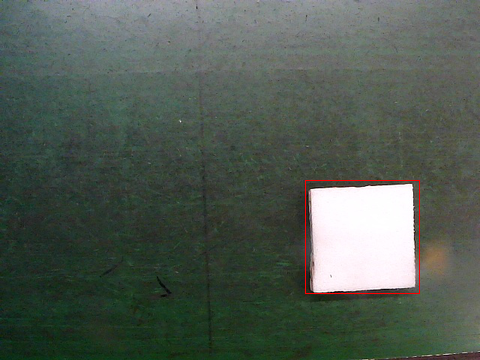

In [6]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190505121605.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['book']))

In [7]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173123.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['book']))

execute1 time 0.18765974044799805
0.0
{}
execute2 time 0.19295907020568848
0


KeyError: 'book'

execute1 time 2.0509660243988037
1.0
scres[i 0.42652097
boxes [0.31827015 0.5754107  0.6312168  0.7971815 ]
rect,width=106.44996643066406height=-112.66080379486084
(left, right, top, bottom) (276.19714736938477, 382.6471138000488, 114.57725286483765, 227.2380566596985)
{72: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEB2AF736A0>}
tv
execute2 time 2.121262311935425
1



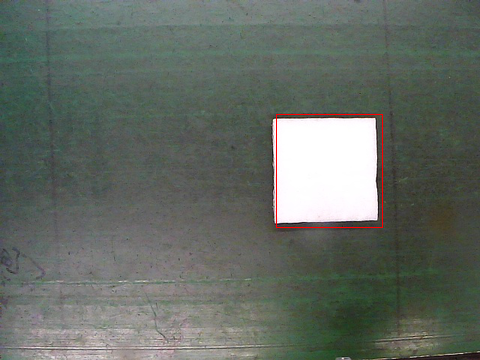

In [11]:
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'

client = ObjectDetector()
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173123.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

In [12]:
import glob
import os
datav=[]
for name in glob.glob('/home/aadebugergf/aixgf/tzimagedata/dqn/*.jpg'):

    if  os.path.basename(name).startswith('object20190520'):
            
            if os.path.basename(name) >='object20190510121814.jpg':
                print("ok",name)
 
                result=detect_objects(name)
                datav.append(name)
print(datav)
print(len(datav))

ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173539.jpg
execute1 time 0.22492504119873047
0.0
{}
execute2 time 0.23024940490722656
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173204.jpg
execute1 time 0.2251265048980713
1.0
scres[i 0.4590196
boxes [0.3589008 0.571665  0.6690657 0.8023998]
rect,width=110.75271606445312height=-111.65937423706055
(left, right, top, bottom) (274.3991947174072, 385.15191078186035, 129.20428276062012, 240.86365699768066)
{72: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEBB9875D30>}
tv
execute2 time 0.29572606086730957
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173223.jpg
execute1 time 0.22537446022033691
1.0
scres[i 0.30960277
{}
execute2 time 0.2307291030883789
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173431.jpg
execute1 time 0.22774934768676758
0.0
{}
execute2 time 0.23305583000183105
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173422.jpg
execute1 time 0.22563481330871582
0.0
{}
exe

execute1 time 2.0828118324279785
1.0
scres[i 0.54042906
boxes [0.427283   0.5770585  0.73602515 0.8058192 ]
rect,width=109.80514526367188height=-111.14717960357666
(left, right, top, bottom) (276.9880771636963, 386.79322242736816, 153.82187604904175, 264.9690556526184)
{72: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEB436822E8>}
tv
execute2 time 2.150153636932373
1



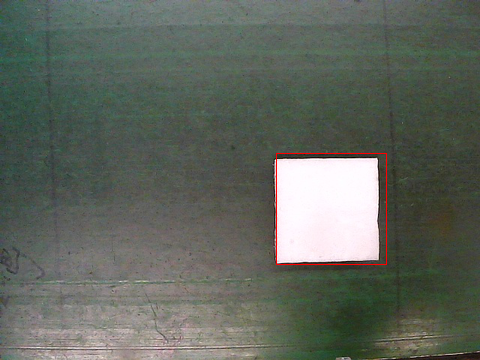

In [13]:
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'

client = ObjectDetector()
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173323.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

execute1 time 0.22057700157165527
1.0
scres[i 0.42652097
boxes [0.31827015 0.5754107  0.6312168  0.7971815 ]
rect,width=106.44996643066406height=112.66080379486084
center= 329.4221305847168 y= 170.90765476226807
scara xy (559.0952490716232, 557.7157499084419)
(left, right, top, bottom) (276.19714736938477, 382.6471138000488, 114.57725286483765, 227.2380566596985)
{72: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEBBA272710>}
tv
execute2 time 0.2908010482788086
1



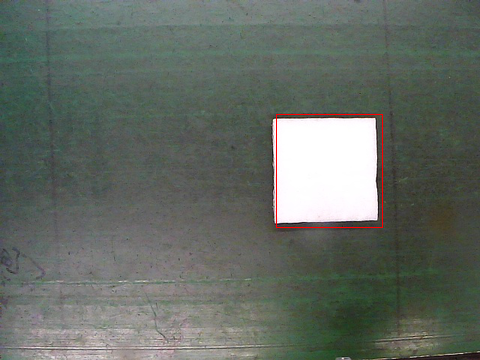

In [41]:
filename='/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173123.jpg'

result=detect_objects(filename)
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

In [16]:
filename='/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173133.jpg'

result=detect_objects(filename)
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

execute1 time 0.22329044342041016
0.0
{}
execute2 time 0.22860074043273926
0


KeyError: 'tv'

In [39]:
filename='/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173143.jpg'

result=detect_objects(filename)
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

execute1 time 0.18285632133483887
0.0
{}
execute2 time 0.18814420700073242
0


KeyError: 'tv'

In [53]:
import glob
import os
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'
client = ObjectDetector()
datav=[]

for name in glob.glob('/home/aadebugergf/aixgf/tzimagedata/dqn/*.jpg'):

    if  os.path.basename(name).startswith('object20190520'):
            
            if os.path.basename(name) >='object20190510121814.jpg':
                print("ok",name)
 
#                result=detect_objects(name)
                datav.append(name)

print(len(datav))
datav.sort()

def detect(name):
    print(name)
    result=detect_objects(name)

overv=map(lambda item:detect(item),datav)
print(list(overv))

ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173539.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173204.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173223.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173431.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173422.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173323.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173704.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173558.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173333.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173723.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173343.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173233.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173123.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173313.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/objec

execute1 time 0.22318315505981445
0.0
{}
execute2 time 0.22849297523498535
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173422.jpg
execute1 time 0.22264814376831055
0.0
{}
execute2 time 0.2279350757598877
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173431.jpg
execute1 time 0.22601318359375
0.0
{}
execute2 time 0.2313227653503418
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173441.jpg
execute1 time 0.22610044479370117
0.0
{}
execute2 time 0.23139238357543945
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173451.jpg
execute1 time 0.2236018180847168
0.0
{}
execute2 time 0.22890758514404297
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173500.jpg
execute1 time 0.22217488288879395
0.0
{}
execute2 time 0.22747302055358887
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173510.jpg
execute1 time 0.22704339027404785
0.0
{}
execute2 time 0.23234844207763672
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173520.jpg
execute1 time 0.2282960414

execute1 time 2.08858585357666
1.0
scres[i 0.42652097
boxes [0.31827015 0.5754107  0.6312168  0.7971815 ]
image size  (480, 360)
enlarge = 368.2628631591797 510.19615173339844 152.7696704864502 302.98407554626465
rect,width=106.44996643066406height=112.66080379486084
center= 329.4221305847168 y= 170.90765476226807
scara xy (460.95618879333097, 507.98344017492263)
(left, right, top, bottom) (276.19714736938477, 382.6471138000488, 114.57725286483765, 227.2380566596985)
{72: <PIL.Image.Image image mode=RGB size=480x360 at 0x7FEB2BB11860>}
tv
execute2 time 2.1587905883789062
1



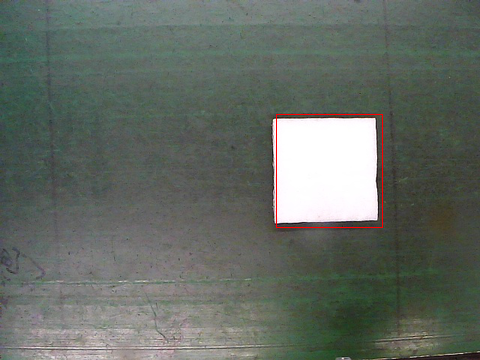

In [50]:
filename='/home/aadebugergf/aixgf/tzimagedata/dqn/object20190520173123.jpg'
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'
client = ObjectDetector()
result=detect_objects(filename)
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

In [2]:
import glob
import os
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'
client = ObjectDetector()
datav=[]

for name in glob.glob('/home/aadebugergf/aixgf/tzimagedata/dqn/*.jpg'):

    if  os.path.basename(name).startswith('object20190521'):
            
            if os.path.basename(name) >='object20190510121814.jpg':
                print("ok",name)
 
#                result=detect_objects(name)
                datav.append(name)

print(len(datav))
datav.sort()

def detect(name):
    print(name)
    result=detect_objects(name)

overv=map(lambda item:detect(item),datav)
print(list(overv))

ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173752.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173654.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173802.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173408.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173723.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173418.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173811.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173348.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173457.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173743.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173447.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173258.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173358.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173556.jpg
ok /home/aadebugergf/aixgf/tzimagedata/dqn/objec

execute1 time 0.22538471221923828
0.0
{}
execute2 time 0.23058581352233887
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173859.jpg
execute1 time 0.2241497039794922
0.0
{}
execute2 time 0.22946476936340332
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173908.jpg
execute1 time 0.22495770454406738
0.0
{}
execute2 time 0.23024988174438477
/home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173918.jpg
execute1 time 0.22883272171020508
0.0
{}
execute2 time 0.23412632942199707
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [3]:
filename='/home/aadebugergf/aixgf/tzimagedata/dqn/object20190521173318.jpg'
modelname='ssd_inception_v2_coco_2018_01_28'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/'+modelname+'/frozen_inference_graph.pb'
client = ObjectDetector()
result=detect_objects(filename)
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['tv']))

execute1 time 2.0439453125
0.0
{}
execute2 time 2.0492613315582275
0


KeyError: 'tv'